# Suggestions by Anis
- Fully connected dl doesn't work for time series cause it's architecture doesn't allow to fit
- this data suffers from curse of dimensionality as the lagged multivariate features that are very strongly dependent and as a consequence the model underfits (doesn't capture temporal relations), model cannot converge to best solution
- TO GOOGLE: fully connected neural networks for time series
- Shorten the features (remove 7 day lagg)
- number of stacked layers can be increased for LSTM
- Feed LSTM window a longer window, more laggs
- Transformers may also work
- Try RNN

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from copy import deepcopy as dc
from torch.utils.data import DataLoader
import torch
import tqdm

from helper_functions.model_builder import LSTM, VanillaDNN
from helper_functions.data_setup import TimeseriesDataset
from helper_functions.engine import train
from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df.head(), df.shape

(                  Date  Price  FR Generation  FR Load
 0  2018-01-01 00:00:00   4.74        53625.0  56250.0
 1  2018-01-01 01:00:00   3.66        52398.0  54300.0
 2  2018-01-01 02:00:00   1.26        51825.0  53600.0
 3  2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4  2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 (43824, 4))

In [5]:
# Set Date as index
df.Date = pd.to_datetime(df.Date)
df.set_index("Date", inplace=True)

In [6]:
# add dummy variables for weekdays + 7 features
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).weekday == i).astype(int)

# add lagged variables for price + exogenous variables + (92 + 72*N) features
def prepare_dataframe_laggs(df: pd.DataFrame, historical_price_laggs: list =  [1,2,3,7], historical_exo_laggs: list = [1,7]):
    df = dc(df)

    exo_var = df.columns[1:-7]

    laggs = []
    for i in historical_price_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for i in laggs:
        df[f'Price(t-{i})'] = df["Price"].shift(i)

    laggs = []
    for i in historical_exo_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for exo in exo_var:
        for j in laggs:
            df[f'{exo}(t-{j})'] = df[exo].shift(j)

    return df

lagged_df = prepare_dataframe_laggs(df, historical_price_laggs=[1,2,3,7], historical_exo_laggs=[1,7])
lagged_df.dropna(inplace=True)
lagged_df.head()

,Price,FR Generation,FR Load,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,FR Load(t-158),FR Load(t-159),FR Load(t-160),FR Load(t-161),FR Load(t-162),FR Load(t-163),FR Load(t-164),FR Load(t-165),FR Load(t-166),FR Load(t-167)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07 23:00:00,18.91,72256.0,63350.0,0,0,0,0,0,0,1,...,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0,54300.0,56250.0
2018-01-08 00:00:00,15.15,71126.0,59650.0,1,0,0,0,0,0,0,...,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0,54300.0
2018-01-08 01:00:00,15.11,70217.0,57050.0,1,0,0,0,0,0,0,...,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0
2018-01-08 02:00:00,13.42,70273.0,56200.0,1,0,0,0,0,0,0,...,54000.0,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0
2018-01-08 03:00:00,12.91,70608.0,53300.0,1,0,0,0,0,0,0,...,55100.0,54000.0,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0


In [7]:
lagged_df_price_np = lagged_df.iloc[:,:105]
lagged_df_price_np.drop(df.columns[1:10],axis = 1, inplace=True)
lagged_df_price_np.shape

(43657, 96)

In [8]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler
# Transform features by scaling each feature to a given range.
scaler = MinMaxScaler(feature_range=(-1,1))
lagged_df_price_np = RobustScaler().fit_transform(lagged_df_price_np)
# lagged_df_price_np = scaler.fit_transform(lagged_df_price_np)
lagged_df_price_np

array([[-0.50552995, -0.38110599, -0.33993856, ..., -0.78037456,
        -0.74307383, -0.72647059],
       [-0.56328725, -0.50552995, -0.38110599, ..., -1.11097353,
        -0.78021978, -0.74318885],
       [-0.56390169, -0.56328725, -0.50552995, ..., -1.2923696 ,
        -1.11081876, -0.78034056],
       ...,
       [-0.75929339, -0.71582181, -0.63394777, ...,  0.93530413,
         1.06190992,  0.91501548],
       [-0.79400922, -0.75929339, -0.71582181, ...,  0.85079709,
         0.93545891,  1.0620743 ],
       [-0.86344086, -0.79400922, -0.75929339, ...,  0.60609813,
         0.85095187,  0.93560372]])

In [9]:
X = lagged_df_price_np[:, 1:]
y = lagged_df_price_np[:, 0]

# Test set = 2021/01/01 tot 2022/12/12
split_index = df.index.get_loc("2021-01-01 00:00:00")

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26304, 95), (17353, 95), (26304,), (17353,))

In [11]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([26304, 95]),
 torch.Size([17353, 95]),
 torch.Size([26304]),
 torch.Size([17353]))

In [12]:
from torch.utils.data import TensorDataset
# train_dataset = TimeseriesDataset(X_train, y_train, seq_len=2688)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [13]:
# test_dataset = TimeseriesDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = VanillaDNN(95,1024, 1)
model.to(device)
model

VanillaDNN(
  (layer_stack): Sequential(
    (0): Linear(in_features=95, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [16]:
summary(model=model,
        input_size=(32, 95), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VanillaDNN (VanillaDNN)                  [32, 95]             [32, 1]              --                   True
├─Sequential (layer_stack)               [32, 95]             [32, 1]              --                   True
│    └─Linear (0)                        [32, 95]             [32, 1024]           98,304               True
│    └─ReLU (1)                          [32, 1024]           [32, 1024]           --                   --
│    └─Linear (2)                        [32, 1024]           [32, 1024]           1,049,600            True
│    └─ReLU (3)                          [32, 1024]           [32, 1024]           --                   --
│    └─Linear (4)                        [32, 1024]           [32, 1024]           1,049,600            True
│    └─ReLU (5)                          [32, 1024]           [32, 1024]           --                   --
│    └─Linear (6)   

In [17]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training with help from engine.py
train(model=model,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             loss_fn=loss_function,
             optimizer=optimizer,
             epochs=10,
             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 7.0505 | train_MAE: 0.3899 | test_loss: 2.9913 | test_MAE: 1.2033
Epoch: 2 | train_loss: 0.0526 | train_MAE: 0.1439 | test_loss: 1.9057 | test_MAE: 0.8921
Epoch: 3 | train_loss: 0.0516 | train_MAE: 0.1414 | test_loss: 7.7395 | test_MAE: 2.0007
Epoch: 4 | train_loss: 1.5115 | train_MAE: 0.2590 | test_loss: 5138.5213 | test_MAE: 50.9133
Epoch: 5 | train_loss: 0.1229 | train_MAE: 0.1818 | test_loss: 7.9892 | test_MAE: 2.0560
Epoch: 6 | train_loss: 0.0628 | train_MAE: 0.1691 | test_loss: 7.9868 | test_MAE: 2.0555
Epoch: 7 | train_loss: 0.0629 | train_MAE: 0.1694 | test_loss: 8.0076 | test_MAE: 2.0598
Epoch: 8 | train_loss: 0.0626 | train_MAE: 0.1689 | test_loss: 8.0124 | test_MAE: 2.0607
Epoch: 9 | train_loss: 0.0625 | train_MAE: 0.1688 | test_loss: 8.0055 | test_MAE: 2.0593
Epoch: 10 | train_loss: 0.0627 | train_MAE: 0.1692 | test_loss: 7.9836 | test_MAE: 2.0549


{'train_loss': [7.050473445816274,
  0.052628067371360686,
  0.05161435851417119,
  1.5114589634395619,
  0.12289408337123184,
  0.06279652035107423,
  0.06293705097425711,
  0.06260467196787524,
  0.06248526573787305,
  0.06273392068478222],
 'train_acc': [0.38991340628650645,
  0.14385954459218214,
  0.14138910734069754,
  0.25900013507808356,
  0.18178390376179177,
  0.16909214406933662,
  0.16944350053866705,
  0.16888029722909279,
  0.16878633803422868,
  0.1691939570372267],
 'test_loss': [2.9913306807341056,
  1.905671348984818,
  7.7395449997111125,
  5138.5213106093215,
  7.989199198267901,
  7.986779453133406,
  8.007645538296297,
  8.012366696494128,
  8.005485234773523,
  7.98355813860262],
 'test_acc': [1.203318835965068,
  0.8921092593455842,
  2.000740604080658,
  50.913323491482444,
  2.056025215453755,
  2.055548462817792,
  2.0597630626835874,
  2.060718169761736,
  2.0593263620363196,
  2.0548986246462904]}

In [22]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

fitting a time series as if they're independent, but there's a strong relation between them, so colinearity is a large issue, so the model doesn't perform well

In [23]:
predicted

array([[-0.0859368],
       [-0.0859368],
       [-0.0859368],
       ...,
       [-0.0859368],
       [-0.0859368],
       [-0.0859368]], dtype=float32)

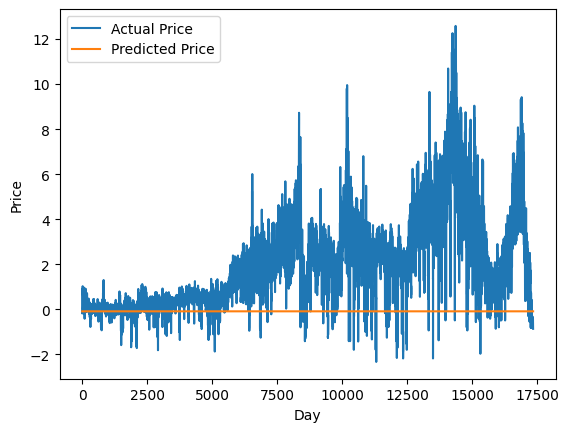

In [24]:
plt.plot(y_test, label="Actual Price")
plt.plot(predicted, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")

plt.legend()
plt.show()

In [21]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

2198529